In [1]:
# -*- coding: utf-8 -*-
from __future__ import division

이 튜토리얼에서는, tensorflow를 이용하여 style transfer를 단계별로 구현해보는 과정을 다룹니다. [Cameron Smith의 구현](https://github.com/cysmith/neural-style-tf) 을 참조하였으며, 위 페이지에는 튜토리얼은 없으나 style transfer의 다양한 구현 예시가 있습니다.

# 준비할것들
- tensorflow (1.3 version / gpu 버전 추천)
- numpy
- python 2
- scipy
- opencv
- VGG 19 weight (학습된 cnn 모델) [imagenet-vgg-verydeep-19](http://www.vlfeat.org/matconvnet/pretrained/)
링크에서 파일을 다운로드 받아, style_transfer 폴더에 넣어주세요.

튜토리얼을 진행하다 오류가 발생하면, 문제가 발생한 코드의 버전 호환성을 확인해보거나 아래의 버전으로 맞춰 보시는 것을 추천합니다.

In [2]:
# check requirement
import tensorflow as tf
import cv2
import numpy as np
import os
import scipy.io

print('tensorflow version : {}'.format(tf.__version__))
print('opencv version : {}'.format(cv2.__version__))
print('numpy version : {}'.format(np.__version__))
if os.path.isfile('imagenet-vgg-verydeep-19.mat'):
    print('vgg weight ready')
else:
    print('you need vgg19 weight')
    raise Exception('no vgg19 file')

tensorflow version : 1.3.1
opencv version : 3.3.0
numpy version : 1.13.3
vgg weight ready


# Style transfer 소개

Style Transfer의 목적은 특정 스타일을 가진 이미지 A와, 또 다른(A와 다른 물체들(context)을 가진) 이미지 B가 있을 때, 물체들은 B와 같고 스타일은 A와 같은 새로운 이미지 C를 만들어 내는 것입니다.

이를 위해서 이미 학습된 CNN을 사용하게 되는데, 스타일은 이미지 A를 CNN에 넣었을 때(feed-forward 시켰을때) layer activation의 Gram matrix로,
물체들은 이미지 B를 CNN에 넣었을 때의 상위 layer에서의 activation으로 표현된다고 가정합니다.

이미지 C는, CNN에 C를 넣었을때 layer의 Gram matrix는 이미지 A를 넣었을때의 Gram matrix와 차이가 작아지도록, 상위 layer의 activation은 이미지 B를 넣었을 때 activation과 차이가 작아지도록 반복하여 optimization하여 얻게 됩니다. 보통 네트워크를 학습시킬때, backpropagation을 이용하여 network weight를 학습한다면, Style transfer 에서는 network weight는 고정시키고, 이미지 C를 변수로 생각하여 업데이트 하게 됩니다.

Style Transfer의 자세한 이론은 [Image Style Transfer Using Convolutional Neural Networks](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf)을 참고하시기 바랍니다.

# 이미지 읽어들이기
가장 먼저, 변환하고자 하는 이미지(B)와 스타일 이미지(A)를 읽어들입니다. 전혀 다른 이미지, 혹은 랜덤한 노이즈로 구성된 이미지로 부터 시작해서 컨텐츠와 스타일을 적용할 수도 있지만, 여기서는 컨텐츠 이미지(B)를 시작 이미지(C)로서 사용합니다.

In [3]:
def read_image(path):
    # openCV를 이용하면 bgr 순서로 이미지를 읽게 됩니다.
    bgr_img = cv2.imread(path) 
    # bgr -> rgb
    rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    
    # 간단히 하기 위해, 이미지의 크기를 변환시킵니다. (h = 480, w = 640)
    # 스타일 이미지(A), 컨텐츠 이미지(B), 만드려는 이미지(C)의 크기는 모두 같게 해주어야 합니다.
    
    rgb_img = cv2.resize(rgb_img, dsize=(640, 480)) # (w, h)
    
    # numpy array로 변환
    rgb_img = rgb_img.astype(np.float32) # shape(h, w, d)   
    # normalization. VGG-19 를 학습시킬때에, 이미지를 normalization 하여 학습시켰으므로 
    # 여기서도 같은 값으로 normalization 해주어야 합니다.
    norm_constant = np.array([123.68, 116.779, 103.939])
    rgb_img -= norm_constant.reshape(1,1,3)
    
    # network에 넣어주기 위해, axis=0를 추가합니다 (batch dimension=1)
    rgb_img = rgb_img[np.newaxis,:,:,:] # shape(1, h, w, d)   
    
    return rgb_img

In [4]:
style_img = read_image('images/style_gogh.jpg')

In [5]:
style_img.shape

(1, 480, 640, 3)

In [6]:
# 이미지의 일부의 값을 직접 확인. (0.00000031의 값은 부동 소수점 에러로 인해 생깁니다.)
style_img[:,:10,:10,0]

array([[[ -68.68000031,  -90.68000031,  -98.68000031,  -95.68000031,
          -91.68000031,  -81.68000031,  -93.68000031,  -89.68000031,
          -95.68000031,  -91.68000031],
        [ -67.68000031,  -89.68000031,  -89.68000031,  -81.68000031,
          -93.68000031,  -96.68000031,  -96.68000031,  -88.68000031,
          -90.68000031,  -79.68000031],
        [ -90.68000031,  -87.68000031,  -92.68000031, -103.68000031,
          -99.68000031, -108.68000031, -106.68000031, -103.68000031,
         -104.68000031, -106.68000031],
        [ -84.68000031,  -90.68000031, -102.68000031,  -99.68000031,
         -102.68000031, -112.68000031, -109.68000031, -103.68000031,
         -105.68000031, -111.68000031],
        [ -89.68000031,  -91.68000031,  -93.68000031,  -96.68000031,
         -110.68000031,  -89.68000031,  -97.68000031, -107.68000031,
         -101.68000031,  -95.68000031],
        [ -90.68000031,  -88.68000031,  -97.68000031, -100.68000031,
         -105.68000031,  -97.68000031,  -

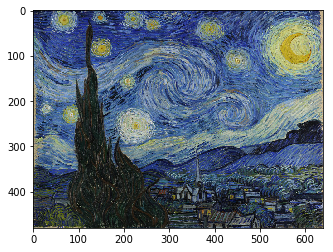

In [7]:
# 이미지를 그리기 위해서는, normalization factor를 다시 더해주어야 합니다.
import matplotlib.pyplot as plt
%matplotlib inline
norm_constant = np.array([123.68, 116.779, 103.939])
img = style_img[0,:,:,:] + norm_constant.reshape(1,1,3)
img = np.clip(img, 0, 255).astype('uint8')
plt.imshow(img)

# model 읽어오기 

.mat 형태로 저장되어있는 VGG-19의 weight를 이용하여 주어진 이미지 크기에 맞는 새로운 CNN을 만듭니다. .mat파일을 파싱하는 과정은 model.py를 참고하여 주세요.

In [8]:
import model
net = model.build_model(style_img)

In [9]:
net

{'conv1_1': <tf.Tensor 'Conv2D:0' shape=(1, 480, 640, 64) dtype=float32>,
 'conv1_2': <tf.Tensor 'Conv2D_1:0' shape=(1, 480, 640, 64) dtype=float32>,
 'conv2_1': <tf.Tensor 'Conv2D_2:0' shape=(1, 240, 320, 128) dtype=float32>,
 'conv2_2': <tf.Tensor 'Conv2D_3:0' shape=(1, 240, 320, 128) dtype=float32>,
 'conv3_1': <tf.Tensor 'Conv2D_4:0' shape=(1, 120, 160, 256) dtype=float32>,
 'conv3_2': <tf.Tensor 'Conv2D_5:0' shape=(1, 120, 160, 256) dtype=float32>,
 'conv3_3': <tf.Tensor 'Conv2D_6:0' shape=(1, 120, 160, 256) dtype=float32>,
 'conv3_4': <tf.Tensor 'Conv2D_7:0' shape=(1, 120, 160, 256) dtype=float32>,
 'conv4_1': <tf.Tensor 'Conv2D_8:0' shape=(1, 60, 80, 512) dtype=float32>,
 'conv4_2': <tf.Tensor 'Conv2D_9:0' shape=(1, 60, 80, 512) dtype=float32>,
 'conv4_3': <tf.Tensor 'Conv2D_10:0' shape=(1, 60, 80, 512) dtype=float32>,
 'conv4_4': <tf.Tensor 'Conv2D_11:0' shape=(1, 60, 80, 512) dtype=float32>,
 'conv5_1': <tf.Tensor 'Conv2D_12:0' shape=(1, 30, 40, 512) dtype=float32>,
 'conv5_2'

이제 net\['layer_name'\] 으로 특정 layer에 접근할 수 있습니다. 

여기서 얻는 텐서는 이미지를 넣어 tensorflow session을 run 해야만 값을 가지게 됩니다.

In [10]:
net['conv4_1']

<tf.Tensor 'Conv2D_8:0' shape=(1, 60, 80, 512) dtype=float32>

In [11]:
# style image를 넣었을때, conv4_1 의 값을 구해봅니다.
sess = tf.Session()

# 이미지를 넣어줍니다.
sess.run(net['input'].assign(style_img))

# 이때 conv4_1의 값을 얻습니다.
value_conv4_1 = sess.run(net['conv4_1'])
sess.close()

In [12]:
value_conv4_1.shape

(1, 60, 80, 512)

In [13]:
# conv4_1의 첫번째 채널의 값을 직접 확인해봅니다.
value_conv4_1[0,:,:,0]

array([[ -865.40777588,  -373.38787842,   268.84274292, ...,
          -20.96800232,   347.83609009,  1211.20776367],
       [ -941.9151001 ,    -1.62741852,    60.62447357, ...,
          216.85054016,  -247.21562195,   821.51269531],
       [-1107.3840332 ,   272.17715454,  -311.48355103, ...,
          786.26611328,  -280.24865723,   631.68847656],
       ..., 
       [  153.21655273,  1258.86035156,   976.11083984, ...,
          990.93774414,   -71.16169739,   520.37304688],
       [ -104.88421631,   580.64294434,  1115.12902832, ...,
         -264.87554932,  -347.64932251,   570.80670166],
       [ -349.7666626 ,   273.86190796,   695.11499023, ...,
         -460.41000366,  -234.67619324,   459.08157349]], dtype=float32)

# Loss 정의하기

앞서 소개에서 간략하게 언급하였듯이, Style을 비슷하게 만들기 위해서는 layer의 Gram matrix를, Contents를 비슷하게 만들기 위해서는 layer의 activation 자체를 비슷하게 만들어야 합니다. 이를 위해서, 생성하고자 하는 이미지에서 얻은 값과 원하는 Style 이미지 / Contents 이미지의 값을 차이를 Loss로 정의합니다.

In [14]:
# Style loss의 정의

def gram_matrix(x, area, depth):
    x = tf.reshape(x, (area, depth))
    gram = tf.matmul(tf.transpose(x), x)
    return gram

def loss_style(sess, net, style_image, layers):
    total_style_loss = 0
    sess.run(net['input'].assign(style_image))
    for el in layers:
        layer_value_style = sess.run(net[el])
        layer_value_target = tf.convert_to_tensor(net[el])
        _, h, w, d = layer_value_style.shape
        area = h * w
        depth = d
        gram_style = gram_matrix(layer_value_style, area, depth)
        gram_target = gram_matrix(layer_value_target, area, depth)
        layer_loss = tf.reduce_sum(tf.pow(gram_style - gram_target, 2)) / (4 * depth**2 * area**2)
        total_style_loss += layer_loss
    # layer 수만큼 나누어 normalize 합니다.
    total_style_loss /= len(layers)
    return total_style_loss

In [15]:
# Contents loss의 정의

def loss_content(sess, net, content_image, layers):
    total_content_loss = 0
    sess.run(net['input'].assign(content_image))
    for el in layers:
        layer_value_content = sess.run(net[el])
        layer_value_target = tf.convert_to_tensor(net[el])
        _, h, w, d = layer_value_content.shape
        area = h * w
        depth = d
        layer_loss = tf.reduce_sum(tf.pow(layer_value_content - layer_value_target, 2)) / (2 * depth**0.5 * area**0.5)
        total_content_loss += layer_loss
    total_content_loss /= len(layers)
    return total_content_loss

# Optimization 하기

이제, 만들어진 network와 loss를 이용하여, 이미지 C를 optimization하여 만듭니다.

In [16]:
sess = tf.Session()
style_img = read_image('images/style_gogh.jpg')
content_img = read_image('images/contents_han.jpg')
init_img = content_img

# style을 2_1 / 3_1 번째 layer의 relu로 부터, content를 4_2번째 conv의 값으로 부터 얻습니다. 
# layer를 추가하거나 빼서 다른 결과를 얻을 수 있습니다.
L_style = loss_style(sess, net, style_img, ['relu2_1', 'relu3_1'])
L_content = loss_content(sess, net, content_img, ['conv4_2'])

# L_style 과 L_content의 scale이 다르므로, 비율을 적당히 맞춰주기 위해 weighted sum을 합니다. 
# 여기서 weight의 비율을 바꾸어 style 혹은 content의 비중을 조절할 수 있습니다.
weight_style = 1e4
weight_content = 5e0
L_total = weight_style * L_style + weight_content * L_content

#논문에서는 L-BFGS를 썼으나, 여기서는 adam을 사용하겠습니다. L-BFGS를 사용한 optimization 방법은 
# [Cameron Smith의 구현](https://github.com/cysmith/neural-style-tf)을 참고하세요

# optimizer를 정의합니다.
optimizer = tf.train.AdamOptimizer(1e0)
train_op = optimizer.minimize(L_total)

# initialization
sess.run(tf.global_variables_initializer())
sess.run(net['input'].assign(init_img))

for iter in range(500):
    sess.run(train_op)
    if iter % 50 == 0:
        print('iter={:d}, loss={:.5e}'.format(iter, L_total.eval(session=sess)))

output_img = sess.run(net['input'])

iter=0, loss=1.35231e+11
iter=50, loss=8.04368e+09
iter=100, loss=3.55697e+09
iter=150, loss=2.29247e+09
iter=200, loss=1.74236e+09
iter=250, loss=1.44424e+09
iter=300, loss=1.25800e+09
iter=350, loss=1.12963e+09
iter=400, loss=1.03526e+09
iter=450, loss=9.62810e+08


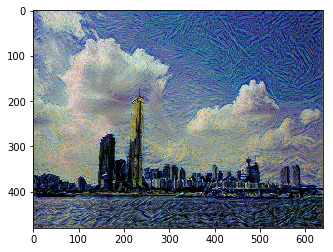

In [17]:
# normalize한 수치를 다시 되돌립니다.
norm_constant = np.array([123.68, 116.779, 103.939])
output_img = output_img[0,:,:,:] + norm_constant.reshape(1,1,3)
output_img = np.clip(output_img, 0, 255).astype('uint8')
plt.imshow(output_img)

In [18]:
# 저장하기
# rgb->bgr
bgr_img = cv2.cvtColor(output_img, cv2.COLOR_RGB2BGR)
# save image
cv2.imwrite('images/output.jpg', bgr_img)


True